In [4]:
print ('Kernel readay')

Kernel readay


In [3]:
# import required modules
import os
import pandas as pd
import numpy as np
import random

from sklearn import metrics
import logging

In [4]:
#general variables

cols = ['img_id','gt_bbox','gt_format','pred_bbox','pred_format','confidence','gt_size','iou']


# Get results table
* Inputs: 
    * txt files from inference.py
* Outputs:
    * results\_{set}\_\{model}.csv with for one row per image, and cols: img_id, gt_bbox	gt_format, pred_bbox,	pred_format,	confidence,	gt_size,	iou

## Write results table to csv

In [ ]:
from Write_results_csv import *

In [ ]:
path_to_root = '../../..'

GT_bbox_Dir = os.path.join(path_to_root, 'data/yolov3-inputs_imagery-7-25_cropped_419/validation_set/labels/')
Pred_bbox_Dir = os.path.join(path_to_root, 'outputs/fasterRCNN_07_27_newimagery/export_inference/validationset_inference_fasterRCNN_07_27_newimagery')
gt_format = 'xywh_pix'
pred_format = 'y1x1y2x2_pix'

outputFile = os.path.join(path_to_root, 'results/results_validation_fasterRCNN-07-27_.csv')

detect_df = make_results_table(GT_bbox_Dir, Pred_bbox_Dir, outputFile, gt_format, pred_format)


## Load an existing results table

In [4]:
# Load csv
path_to_root = '../../..'
path_to_rez_table = os.path.join(path_to_root,'results','results_validation_fasterRCNN-07-27_.csv')
results_df = pd.read_csv(path_to_rez_table)
results_df.head()

img_id            gt_bbox  gt_format          pred_bbox    pred_format  \
0    2672  [305 300 377 382]  xywh_norm  [354 302 312 382]  y1x1y2x2_norm   
1  125569  [185 198 356 343]  xywh_norm  [348 189 218 376]  y1x1y2x2_norm   
2  125730  [106  94 246 258]  xywh_norm  [259 137 118 199]  y1x1y2x2_norm   
3  105933  [314 321 357 350]  xywh_norm  [355 322 324 355]  y1x1y2x2_norm   
4    8124  [176 192 220 204]  xywh_norm  [153 121 128 138]  y1x1y2x2_norm   

   confidence  gt_size       iou  
0      0.8374   5904.0  0.484615  
1      0.8801  24795.0  0.739462  
2      0.9283  22960.0  0.377031  
3      0.8858   1247.0  0.607649  
4      0.1947    528.0  0.000000

## Filter by size
Size is based on ground truth bounding box size, in pixel. "Small dams" at size of interest are between 500 to 1800 pixels.

In [5]:
results_table_name = 'results_validation_fasterRCNN-07-27_.csv'

results_df_vsmall = results_df[results_df['gt_size']<500]
results_df_smalldams = results_df[(results_df['gt_size']>=500) & (results_df['gt_size']<=1800)]
results_df_vbig = results_df[results_df['gt_size']>1800]

In [11]:
##Print dataset stats

num_imgs = len(results_df)
num_dams = np.where(results_df.gt_bbox.notnull(), 1, 0).sum()

print('For this set from ',results_table_name,':')
print(' ')
print('-- ',len(results_df),' images total')
print('--  {} ({:.0f}%) are dams'.format(num_dams,num_dams/num_imgs*100))

print('    of which --  {:.1f}% are "Small dams" (size of interest 500-1800)'.format(len(results_df_smalldams)/num_dams*100))
print('             --  {:.1f}%% are smaller'.format(len(results_df_vsmall)/num_dams*100))
print('             --  {:.1f}%% are bigger'.format(len(results_df_vbig)/num_dams*100))

For this set from  results_validation_fasterRCNN-07-27_.csv :
 
--  6560  images total
--  5668 (86%) are dams
    of which --  26.1% are "Small dams" (size of interest 500-1800)
             --  27.9%% are smaller
             --  46.0%% are bigger


# Custom evaluation
* Inputs
    * results\_{set}\_{model}.csv
* Outputs
     * Evaluation metrics:
      - For Dams sizes = _Small dams_
      - Recall @ 5% IoU and ≠ min confidence thresholds.

In [ ]:
# Evaluation utils
from evaluation_utils import *

In [12]:
print('For all dams sizes: \n')
iou_thres = 0.05
for conf_thres in [0.1,0.2,0.3,0.4,0.5,0.7]:
    print('with min. Confidence = '+str(conf_thres))
    results_df = add_result_col (results_df, iou_thres, conf_thres)
    Category = 'Cat@IoU'+str(iou_thres)+'@conf'+str(conf_thres)


    # % of images per category
    count_categories = results_df[cols+[Category]].groupby(Category).count()['img_id']
    num_TP = count_categories['TP']/len(results_df)*100
    num_FP = count_categories['FP']/len(results_df)*100
    num_FPFN = count_categories['FP+FN']/len(results_df)*100

    print('TP: {:.1f}%,  FP: {:.1f}%, FP+FN: {:.1f}%\n'.format(num_TP, num_FP, num_FPFN))

For all dams sizes: 

with min. Confidence = 0.1
TP: 61.4%,  FP: 5.4%, FP+FN: 30.6%

with min. Confidence = 0.2
TP: 57.9%,  FP: 2.6%, FP+FN: 36.8%

with min. Confidence = 0.3
TP: 54.3%,  FP: 1.7%, FP+FN: 41.4%

with min. Confidence = 0.4
TP: 50.5%,  FP: 1.2%, FP+FN: 45.7%

with min. Confidence = 0.5
TP: 45.5%,  FP: 0.9%, FP+FN: 51.0%

with min. Confidence = 0.7
TP: 32.5%,  FP: 0.4%, FP+FN: 64.5%



In [187]:
print('For Small dams (500-1800): \n')
iou_thres = 0.05
for conf_thres in [0.1,0.2,0.3,0.4,0.5,0.7]:
    print('with min. Confidence = '+str(conf_thres))
    df = add_result_col(results_df_smalldams, iou_thres, conf_thres)
    Category = 'Cat@IoU'+str(iou_thres)+'@conf'+str(conf_thres)


    # % of images per category
    count_categories = df[cols+[Category]].groupby(Category).count()['img_id']
    num_TP = count_categories['TP']/len(results_df_smalldams)*100 if 'TP' in count_categories.index else 0
    num_FP = count_categories['FP']/len(results_df_smalldams)*100 if 'FP' in count_categories.index else 0
    num_FPFN = count_categories['FP+FN']/len(results_df_smalldams)*100 if 'FP+FN' in count_categories.index else 0
 
    print('TP: {:.1f}%,  FP: {:.1f}%, FP+FN: {:.1f}%\n'.format(num_TP, num_FP, num_FPFN))

For Small dams (500-1800): 

with min. Confidence = 0.1
TP: 73.5%,  FP: 0.0%, FP+FN: 26.4%

with min. Confidence = 0.2
TP: 69.0%,  FP: 0.0%, FP+FN: 30.9%

with min. Confidence = 0.3
TP: 63.2%,  FP: 0.0%, FP+FN: 36.7%

with min. Confidence = 0.4
TP: 56.8%,  FP: 0.0%, FP+FN: 43.2%

with min. Confidence = 0.5
TP: 48.2%,  FP: 0.0%, FP+FN: 51.7%

with min. Confidence = 0.7
TP: 29.5%,  FP: 0.0%, FP+FN: 70.5%



In [14]:
iou = 0.05
conf = 0.1

print('For Small dams in this set:')
r = get_recall_score(results_df_smalldams, iou, conf)
p = get_precision_score(results_df_smalldams, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}, Precision: {:.2f} '.format(iou, conf, r,p),'\n')

print('For all dams in this set:')
r = get_recall_score(results_df, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

print('For too small dams in this set:')
r = get_recall_score(results_df_vsmall, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

print('For too big in this set:')
r = get_recall_score(results_df_vbig, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

For Small dams in this set:
IoU 0.05, Confidence 0.1 --> Recall: 0.74, Precision: 0.87  

For all dams in this set:
IoU 0.05, Confidence 0.1 --> Recall: 0.71
For too small dams in this set:
IoU 0.05, Confidence 0.1 --> Recall: 0.36
For too big in this set:
IoU 0.05, Confidence 0.1 --> Recall: 0.91


In [141]:
iou = 0.05
conf = 0.5

print('For Small dams in this set:')
r = get_recall_score(results_df_smalldams, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r),'\n')

print('For all dams in this set:')
r = get_recall_score(results_df, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

print('For too small dams in this set:')
r = get_recall_score(results_df_vsmall, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

print('For too big in this set:')
r = get_recall_score(results_df_vbig, iou, conf)
print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

For Small dams in this set:
IoU 0.05, Confidence 0.5 --> Recall: 0.48 

For all dams in this set:
IoU 0.05, Confidence 0.5 --> Recall: 0.53
For too small dams in this set:
IoU 0.05, Confidence 0.5 --> Recall: 0.16
For too big in this set:
IoU 0.05, Confidence 0.5 --> Recall: 0.77


In [104]:
for iou in [0, 0.05, 0.2]:
    for conf in [0.3,0.5,0.7,0.9]:
        r = get_recall_score(results_df, iou, conf)
        print('IoU {}, Confidence {} --> Recall: {:.2f}'.format(iou, conf, r))

IoU 0, Confidence 0.3 --> Recall: 0.64
IoU 0, Confidence 0.5 --> Recall: 0.53
IoU 0, Confidence 0.7 --> Recall: 0.38
IoU 0, Confidence 0.9 --> Recall: 0.13
IoU 0.05, Confidence 0.3 --> Recall: 0.63
IoU 0.05, Confidence 0.5 --> Recall: 0.53
IoU 0.05, Confidence 0.7 --> Recall: 0.38
IoU 0.05, Confidence 0.9 --> Recall: 0.13
IoU 0.2, Confidence 0.3 --> Recall: 0.59
IoU 0.2, Confidence 0.5 --> Recall: 0.50
IoU 0.2, Confidence 0.7 --> Recall: 0.36
IoU 0.2, Confidence 0.9 --> Recall: 0.12


# Visualize

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import box

from viz_utils import *

In [7]:
imgDir = os.path.join(path_to_root,'data','inputs_imagery-7-25_cropped_419','validation_set','images')

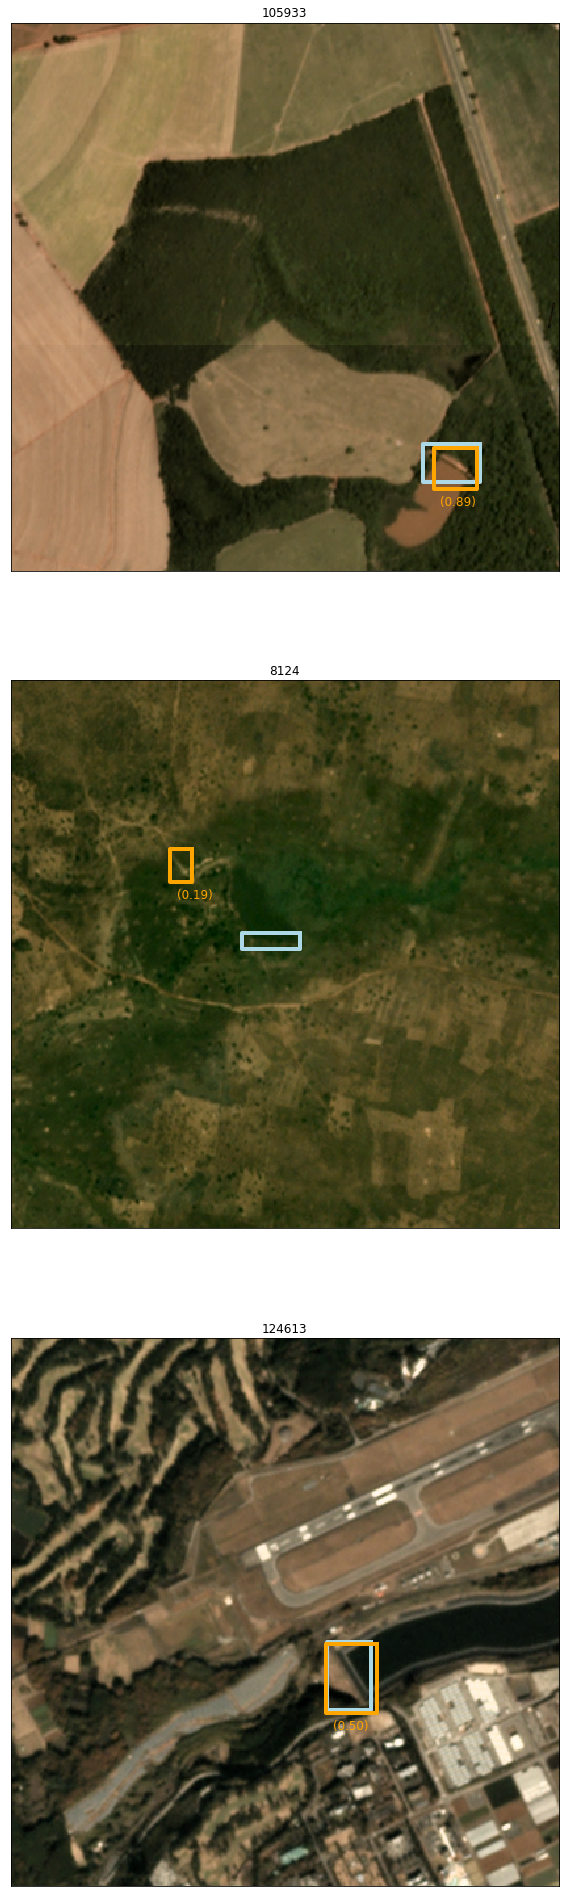

In [8]:
visualize_bboxes(results_df_smalldams.loc[0:10], imgDir)

# Human* baseline performance
\*(Charlie & friends)

### Humans look at:

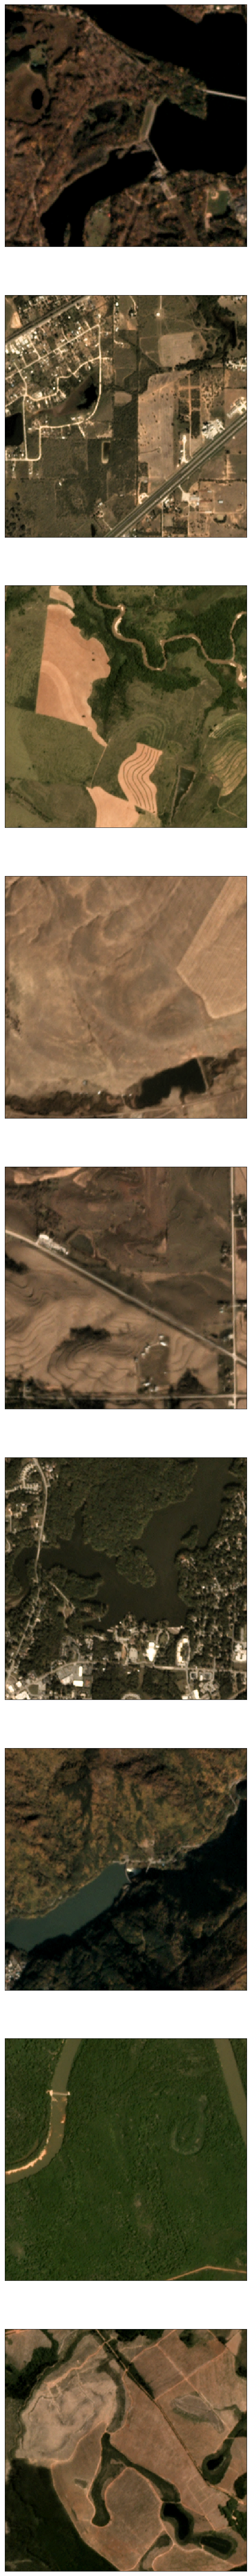

In [231]:
visualize_bboxes(results_df_smalldams.loc[200:250], imgDir,
                 NO_BOXES=True)

### Check against:

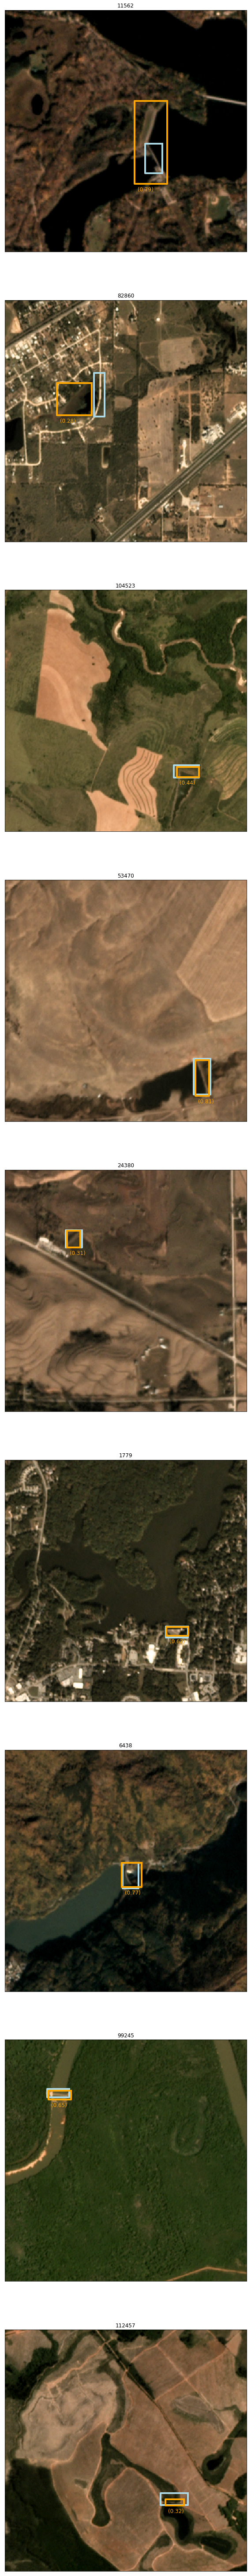

In [230]:
visualize_bboxes(results_df_smalldams.loc[200:250], imgDir)